In [1]:
"""
Voici le notebook pour le test technique chez Padam Mobility.
La consigne était la suivante :  
  - On souhaite déterminer une liste de lignes de bus permettant de desservir un maximum des listes de trajets décrits dans le fichier "OD.csv".
  - Quel est le nombre minimal de ligne de bus pouvant desservir les requêtes ? Sous quelles conditions ?
Ici, il nous est demandé de prendre le problème le plus simplement possible et voilà ce que j'ai fait.

Tout d'abord, dans le fichier "OD.csv" nous avons des longitudes et latitudes de départs et d'arrivées de ligne de bus.
J'ai décidé de fonctionner avec des visualisation d'avant/après les modifications.

Au vu du poblème j'ai directement pensé à regrouper les trajets qui se ressemble.
Grâce à mes fonctions 'is_near', 'get_row', 'matches' je fais un clustering des trajet dont les coordonnées de départ et d'arriver sont les mêmes.
Ainsi les trajets qui se ressemble fortement sont remplacer seulement par un trajet.

La méthode du quotient a été utilisé ici, puisque j'ai quatres variables, je sais alors que si les quotients des mes quatres variables,
d'une ligne par rapport à une autre, sont très proches de 1 alors ils sont quasiment similaire et peuvent être regroupés.
La problématique, ici, fut de savoir comment fixer mes bornes supérieur et inférieur. Après quelques tests j'ai fixé un intervalle de [0,99 ; 1.01]

Mais dans un cas réel ce n'est pas aussi simple. Ici, nous sommes sur Paris et la petite couronne,
supprimé autant de trajet de bus serait trop facile, surtout que nous ne connaissions pas la quantité de personnes empruntant ces bus,
celà pourrait rendre impraticable ces derniers car, au vu de la quantité de trajet supprimé, tout le monde empruntera les bus restants.
Il faut s'assurer qu'il y a la quantité nécessaire de bus, sans en mettre trop car celà ne ferait que déplacer le problème,
pour ainsi réduire les émissions de CO2.

Un autre algorithme efficace à mettre en place serait l'algorithme de Dijkstra, qui nous permettra de trouver le meilleur trajet (principe de path finding),
avec le coût le moins élevé. Ici, vu que nous sommes à vol d'oiseau nous ne prenont pas en compte les obstacles et mettre en place ce genre d'algorithme
ne serait pas très pertinent.

Bonus: J'ai ajouté une carte avec un avant/après suppression des trajets.

Auteur : Fadi El Cheikh Taha  
"""

'\nVoici le notebook pour le test technique chez Padam Mobility.\nLa consigne était la suivante :  \n  - On souhaite déterminer une liste de lignes de bus permettant de desservir un maximum des listes de trajets décrits dans le fichier "OD.csv".\n  - Quel est le nombre minimal de ligne de bus pouvant desservir les requêtes ? Sous quelles conditions ?\nIci, il nous est demandé de prendre le problème le plus simplement possible et voilà ce que j\'ai fait.\n\nTout d\'abord, dans le fichier "OD.csv" nous avons des longitudes et latitudes de départs et d\'arrivées de ligne de bus.\nJ\'ai décidé de fonctionner avec des visualisation d\'avant/après les modifications.\n\nAu vu du poblème j\'ai directement pensé à regrouper les trajets qui se ressemble.\nGrâce à mes fonctions \'is_near\', \'get_row\', \'matches\' je fais un clustering des trajet dont les coordonnées de départ et d\'arriver sont les mêmes.\nAinsi les trajets qui se ressemble fortement sont remplacer seulement par un trajet.\n\nL

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

import folium # For the map

# Loading dataset

In [3]:
df = pd.read_csv("OD.csv", names=['longitude_depart', 'latitude_depart', 'longitude_destination', 'latitude_destination'], delimiter=';')
df

,longitude_depart,latitude_depart,longitude_destination,latitude_destination
0,2.396873,48.856508,2.373364,48.843728
1,2.380738,48.849100,2.346403,48.867927
2,2.327727,48.834761,2.306469,48.871836
3,2.347483,48.865485,2.299668,48.872929
4,2.405835,48.847002,2.332981,48.868067
...,...,...,...,...
631,2.360092,48.863639,2.248475,48.891558
632,2.286708,48.839641,2.246574,48.893540
633,2.316555,48.825422,2.290958,48.874676
634,2.294481,48.858370,2.274342,48.824531


# Data Preparation

In [4]:
# Check for missing or duplicates values
print("Null values ?", df.isnull().values.any(), "\t", "Duplicate values ?", df.duplicated().any())

Null values ? False 	 Duplicate values ? True


In [5]:
# Delete duplicates
df_prepared = df.drop_duplicates(keep='last')
df_prepared.shape

(630, 4)

# Clusterization

In [6]:
# Calculating quotients to determine if the coordinates are close
def is_near(row_1, row_2, RATIO_MIN = 0.99, RATIO_MAX = 1.01): 
    ratios = [row_1["longitude_depart"] / row_2["longitude_depart"], row_1["latitude_depart"] / row_2["latitude_depart"],
              row_1["longitude_destination"] / row_2["longitude_destination"], row_1["latitude_destination"] / row_2["latitude_destination"]]
    for i in ratios:
        if RATIO_MIN <= i <= RATIO_MAX : # Interval set at [0.99 ; 1.01]
            pass
        else:
            return False
    return True

In [7]:
# Get the lines we are interested in
def get_row(row, name):
    if is_near(row, name) == True:
        return row

In [8]:
# We get a single row by cluster
def matches(name, dataframe):
    matches = dataframe.apply(lambda row : get_row(row, name), axis=1)
    return [elem for elem in matches.to_numpy() if elem is not None]

In [9]:
result = df_prepared.apply(lambda row: matches(row, df_prepared), axis=1)
result = [elem[0] for elem in result.to_numpy() if len(elem) > 0]

keepCols = ['longitude_depart', 'latitude_depart', 'longitude_destination', 'latitude_destination']
df_final = pd.DataFrame(result, columns=keepCols).drop_duplicates(keep='last').reset_index(drop=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude_depart       58 non-null     float64
 1   latitude_depart        58 non-null     float64
 2   longitude_destination  58 non-null     float64
 3   latitude_destination   58 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


In [10]:
print("Number of bus routes before clustering :", len(df_prepared))
print("Number of bus routes after clustering :", len(df_final))

Number of bus routes before clustering : 630
Number of bus routes after clustering : 58


# Visualizations

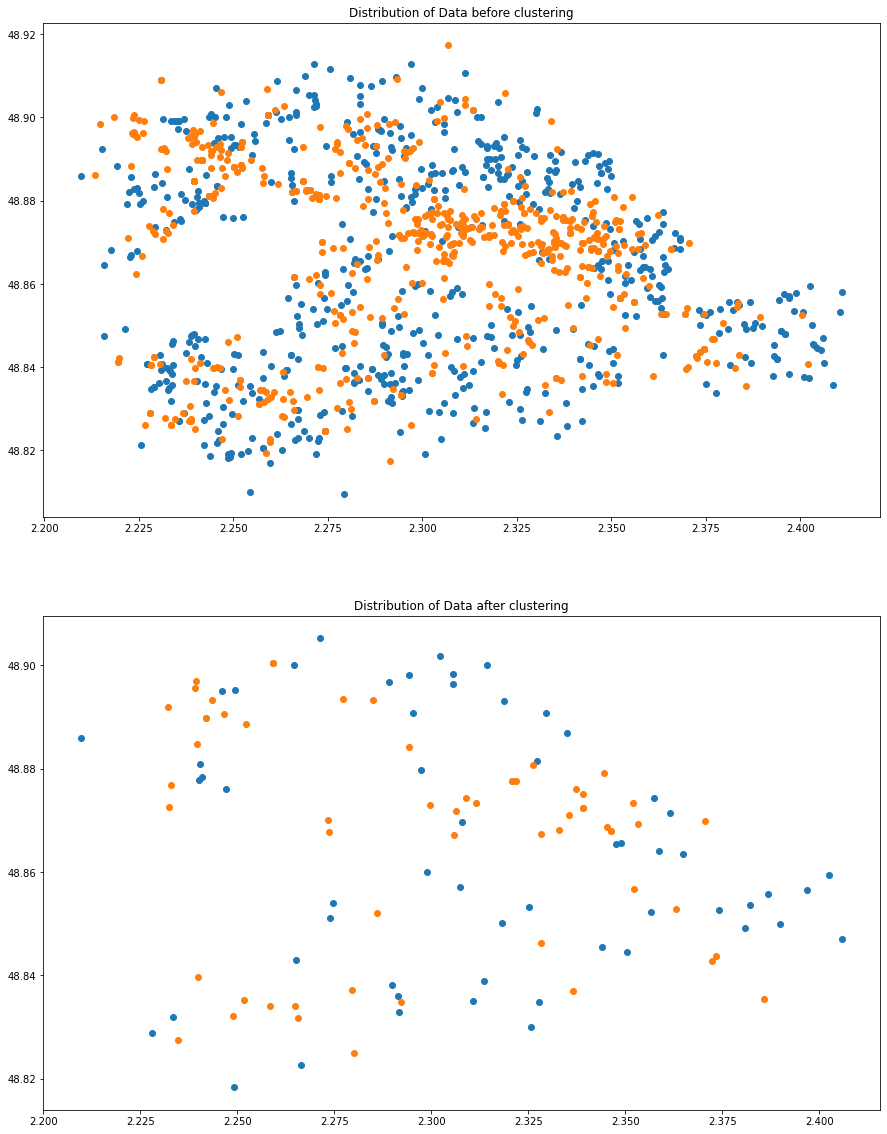

In [11]:
# Plots the before/after clustering
plt.rcParams["figure.figsize"]=[15,20]

# Before
plt.subplot(211)
plt.title('Distribution of Data before clustering')
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.scatter(df.iloc[:,2], df.iloc[:,3])
plt.subplot(212)

# After
plt.title('Distribution of Data after clustering')
plt.scatter(df_final.iloc[:,0], df_final.iloc[:,1])
plt.scatter(df_final.iloc[:,2], df_final.iloc[:,3])
plt.show()

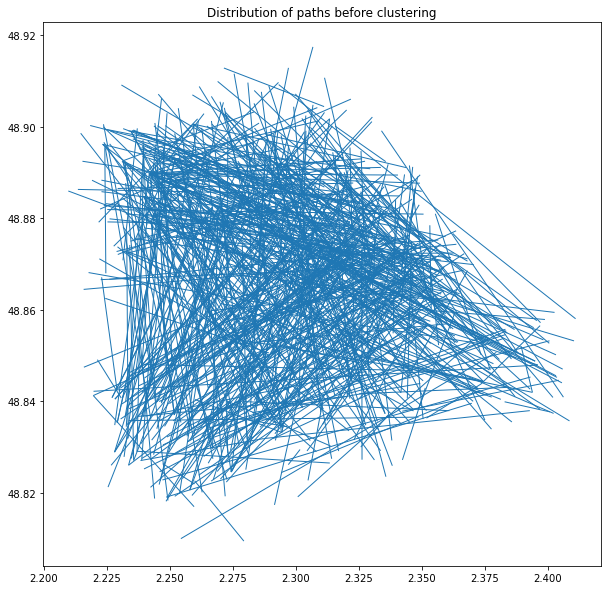

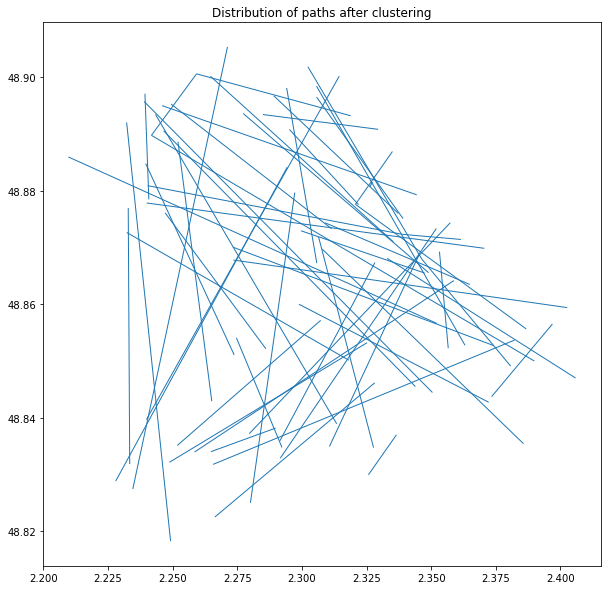

In [12]:
# All paths
lines_before = [[(df['longitude_depart'][i], df['latitude_depart'][i]), (df['longitude_destination'][i], df['latitude_destination'][i])] for i in range(len(df_prepared))]

lc = mc.LineCollection(lines_before, linewidths=1)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Distribution of paths before clustering')
ax.add_collection(lc)
ax.autoscale()

# Paths after clustering
lines_after = [[(df_final['longitude_depart'][i], df_final['latitude_depart'][i]), (df_final['longitude_destination'][i], df_final['latitude_destination'][i])] for i in range(len(df_final))]

lc = mc.LineCollection(lines_after, linewidths=1)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Distribution of paths after clustering')
ax.add_collection(lc)
ax.autoscale()


# Bonus : Map

In [13]:
# Create the map.
map_pickup = folium.Map(location=[48.861817349999995, 2.2950653])

# Adding the latitude and longitude points to the map.
df.apply(lambda row:folium.Marker(location=[row["latitude_depart"], row["longitude_depart"]], icon=folium.Icon(color='blue', icon='bus', prefix='fa') ).add_to(map_pickup), axis=1) # Departures
df.apply(lambda row:folium.Marker(location=[row["latitude_destination"], row["longitude_destination"]], icon=folium.Icon(color='red', icon='bus', prefix='fa') ).add_to(map_pickup), axis=1) # Arrivals

# Display the map.
print("Map before Clusterization\n")
print(u"\u001b[34m Blue marker \u001b[0m", "= Departures \t", u"\u001b[31mRed markers\u001b[0m", "= Arrivals") # ANSI escape codes to print with colors
map_pickup

Map before Clusterization

 Blue marker  = Departures 	 Red markers = Arrivals


In [14]:
# Create the map.
map_pickup = folium.Map(location=[48.861817349999995, 2.2950653])

# Adding the latitude and longitude points to the map.
df_final.apply(lambda row:folium.Marker(location=[row["latitude_depart"], row["longitude_depart"]], icon=folium.Icon(color='blue', icon='bus', prefix='fa')).add_to(map_pickup), axis=1) # Departures
df_final.apply(lambda row:folium.Marker(location=[row["latitude_destination"], row["longitude_destination"]], icon=folium.Icon(color='red', icon='bus', prefix='fa')).add_to(map_pickup), axis=1) # Arrivals

# Display the map.
print("Map after Clusterization\n")
print(u"\u001b[34m Blue marker \u001b[0m", "= Departures \t", u"\u001b[31mRed markers\u001b[0m", "= Arrivals") # ANSI escape codes to print with colors
map_pickup

Map after Clusterization

 Blue marker  = Departures 	 Red markers = Arrivals
